Model orthogonalization with LDM variants (heavily based on Vojta's original code "toymodels.ipynb"). This is an interactive jupyter notebook, that will explore different choices for the construction of the principal components. For now we will only play with the following scenarios:


* 1 good model 1 bad model
* 3 good models 10 bad models
* 1 pefect model, 3 good models, 10 bad models



This is the code hierarchy:

    ├── Utilities
    └── Version 2.0 - LDM variants: Data preparation
    └── PCA - Analysis

        
**I recommend to have Collapsible Headings nbextension active for the best experience.**

## Utilities

In [51]:
pip install corner 


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import corner 


#Some colors that Pablo likes:
colors = [
    "#ff7f0e",

    "#1f77b4",

    "#2ca02c",
    "#d62728",
    
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
] 

markers = [
    "o",  # Circle
    "^",  # Triangle up
    "s",  # Square
    "P",  # Plus (filled)
    "*",  # Star
    "X",  # X (filled)
    "D",  # Diamond
    "H",  # Hexagon
]
def LDM_extended(params, x): 
    #x = (n,z)
    #params= parameters (volume, surface, curv, sym, ssym, sym_2, Coulomb)
    
    n=x[0]
    z=x[1]
    A = n + z
    I = (n-z)/(n+z)
    #I = 0

    return params[0] + params[1] * A ** (-1/3) + params[2] * A ** (-2/3)  +  params[3] * I ** 2 + \
                + params[4] * (I ** 2) * A ** (-1/3) + params[5] * (I ** 4) + params[6]*((z**2)/((n+z)**(4/3))) 




def Truth(x):
    return LDM(LDM_truth_params,x)

def data_loader():
    #input_NZ = pd.read_csv("NZ.txt", delim_whitespace=True, header = None)
    input_NZ = pd.read_csv("NZ_even_even.txt", delim_whitespace=True, header = None)
    input_NZ.columns = ["N", "Z"]
    return input_NZ

def loading_matrix(loadings, n_features, feature_names):
    # Loadings

    # PC names
    pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

    # Match PC names to loadings
    pc_loadings = dict(zip(pc_list, loadings))

    # Matrix of corr coefs between feature names and PCs
    loadings_df = pd.DataFrame.from_dict(pc_loadings)
    loadings_df['feature_names'] = feature_names
    loadings_df = loadings_df.set_index('feature_names')
    return loadings_df

def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, s=5, color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
    return


def plot_bars(values, labels, title="Bar Plot", color='blue'):
    """
    Create a bar plot based on the provided values and labels.

    Parameters:
    - values (list): A list of numerical values for the bars.
    - labels (list): A list of labels for each bar.
    - title (str): The title for the bar plot. Default is "Bar Plot".
    - color (str): Color for the bars. Default is 'blue'.
    """
    
    if len(values) != len(labels):
        raise ValueError("Length of values and labels should be the same.")
    
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Vt Coordinates')
    plt.xticks(labels,fontsize=10,rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()




### Global variables####

# SkO values selected for the truth

truth_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

PerfectM_params = [-15.835, 17.3, 9, 31.98, -58, - 4.5 * (163.5 ** 2) * (0.1605**2) / 223.5,0.57]

# SLy4 
GoodM_params = [-15.972, 18.4, 9, 32.01, -54, - 4.5 * (95.97 ** 2) * (0.1596**2) / 230.1, 0.57]
# NL_1
BadM_params = [-16.425, 18.8, 9, 43.48, -110, -4.5 *(311.18 **2) *(0.1518**2)/211.3, 0.57]



# NL_1 
TerribleM_params = [-15.972, 18.4, 9, 0, 0, 0, 0.57]


noise_term_p=0.01
noise_term_g=0.05
noise_term_b=0.05
noise_term_t=0.05

TestingFraction=0.3





##########################

## Version 2.0 - LDM variants

In [259]:

scenario = "1g1b"
# scenario = "3g10b"
# scenario = "1p3g10b"
# Fix random seed
np.random.seed(142857)
n_perfect =1
n_good = 3
n_bad = 5
n_terrible=10

n_classes=[n_perfect,n_good,n_bad,n_terrible]
n_Labels=["Perfect Model", "Good Models", "Interm. Models","Bad Models"]

# Load NZ
input_NZ =  data_loader()





# masses_truth = LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 

models_output = {}
models_output_train = {}
models_output_test = {}


#Perfect Models Loop
params = PerfectM_params
for i in range(n_perfect):
    models_output[str("PerfectModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_p


#Good Models Loop
params = GoodM_params
for i in range(n_good):
    models_output[str("GoodModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_g

#Bad Models Loop
params = BadM_params
for i in range(n_bad):
    models_output[str("IntermediateModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_b

#Terrible Models Loop
params = TerribleM_params
for i in range(n_terrible):
    models_output[str("BadModel_")+str(i)] = LDM_extended(params,[input_NZ["Z"], input_NZ["N"]])+ np.random.normal(0,1,size=len(input_NZ)) * noise_term_t



# Model_keys=models_output.keys()  #This is done here to have a list of pure models, without the ground truth
key_list=list(models_output.keys())

models_output['truth']=LDM_extended(truth_params,[input_NZ["Z"], input_NZ["N"]]) 


models_output_df = pd.DataFrame(models_output)
models_output_df["N"] = input_NZ["N"]
models_output_df["Z"] = input_NZ["Z"]
models_output_df["A"] = models_output_df["N"] + models_output_df["Z"]


models_output_train, models_output_test = train_test_split(models_output_df, test_size=0.3, random_state=142857)

In [286]:
models_output_train

PerfectModel_0  GoodModel_0  GoodModel_1  GoodModel_2  \
110       -6.600814    -6.365179    -6.370788    -6.424656   
30        -7.019838    -6.762324    -6.733880    -6.824433   
99        -7.096162    -6.926911    -6.894404    -6.911904   
238       -7.757029    -7.638050    -7.660106    -7.604853   
448       -5.677616    -5.533676    -5.652503    -5.599059   
..              ...          ...          ...          ...   
220       -5.516569    -5.356432    -5.410067    -5.351234   
12        -7.436697    -7.313360    -7.193688    -7.138798   
445       -3.773096    -3.639455    -3.692404    -3.667632   
327       -6.316565    -6.219742    -6.229326    -6.264933   
459       -5.837144    -5.748647    -5.799558    -5.726189   

     IntermediateModel_0  IntermediateModel_1  IntermediateModel_2  \
110            -6.826424            -6.875660            -6.973727   
30             -7.321756            -7.381209            -7.438981   
99             -7.443301            -7.498139            -7.379708   
238            -8.012466            -7.896742            -8.141763   
448            -6.025864            -5.980764            -5.910239   
..                   ...                  ...                  ...   
220            -5.899020            -5.901043            -5.888466   
12             -7.529918            -7.618647            -7.555628   
445            -4.134253            -4.004889            -4.024158   
327            -6.588526            -6.607408            -6.686485   
459            -6.205079            -6.160916            -6.158089   

     IntermediateModel_3  IntermediateModel_4  BadModel_0  ...  BadModel_4  \
110            -6.992923            -6.963833   -7.296079  ...   -7.300603   
30             -7.363439            -7.364590   -7.363843  ...   -7.447472   
99             -7.351006            -7.353640   -7.493665  ...   -7.494395   
238            -7.935642            -8.024228   -7.845115  ...   -7.869173   
448            -5.860427            -5.980756   -6.096539  ...   -6.022861   
..                   ...                  ...         ...  ...         ...   
220            -5.914700            -5.789977   -6.405604  ...   -6.474804   
12             -7.619104            -7.528493   -7.293352  ...   -7.279930   
445            -4.069484            -4.143655   -4.821791  ...   -4.846212   
327            -6.598134            -6.523162   -6.706248  ...   -6.631557   
459            -6.144329            -6.150091   -6.189008  ...   -6.252696   

     BadModel_5  BadModel_6  BadModel_7  BadModel_8  BadModel_9     truth  \
110   -7.260826   -7.207416   -7.261362   -7.291811   -7.307945 -6.594775   
30    -7.406082   -7.409022   -7.451118   -7.374763   -7.299121 -7.028283   
99    -7.536949   -7.553211   -7.548399   -7.589621   -7.543981 -7.095374   
238   -7.733040   -7.808011   -7.782970   -7.750894   -7.741057 -7.741870   
448   -6.073197   -6.066352   -6.132554   -6.074582   -6.225333 -5.673257   
..          ...         ...         ...         ...         ...       ...   
220   -6.489240   -6.434357   -6.438482   -6.463720   -6.365334 -5.521216   
12    -7.235994   -7.302914   -7.298927   -7.246502   -7.231786 -7.446512   
445   -4.833001   -4.835498   -4.867978   -4.900735   -4.866618 -3.774199   
327   -6.657141   -6.720975   -6.682154   -6.570661   -6.653700 -6.311904   
459   -6.175014   -6.236612   -6.181881   -6.226465   -6.192328 -5.837750   

       N   Z    A  
110   52  34   86  
30    24  16   40  
99    46  32   78  
238   66  56  122  
448  116  86  202  
..   ...  ..  ...  
220   82  52  134  
12    14  12   26  
445  134  84  218  
327   94  70  164  
459  116  88  204  

[364 rows x 23 columns]

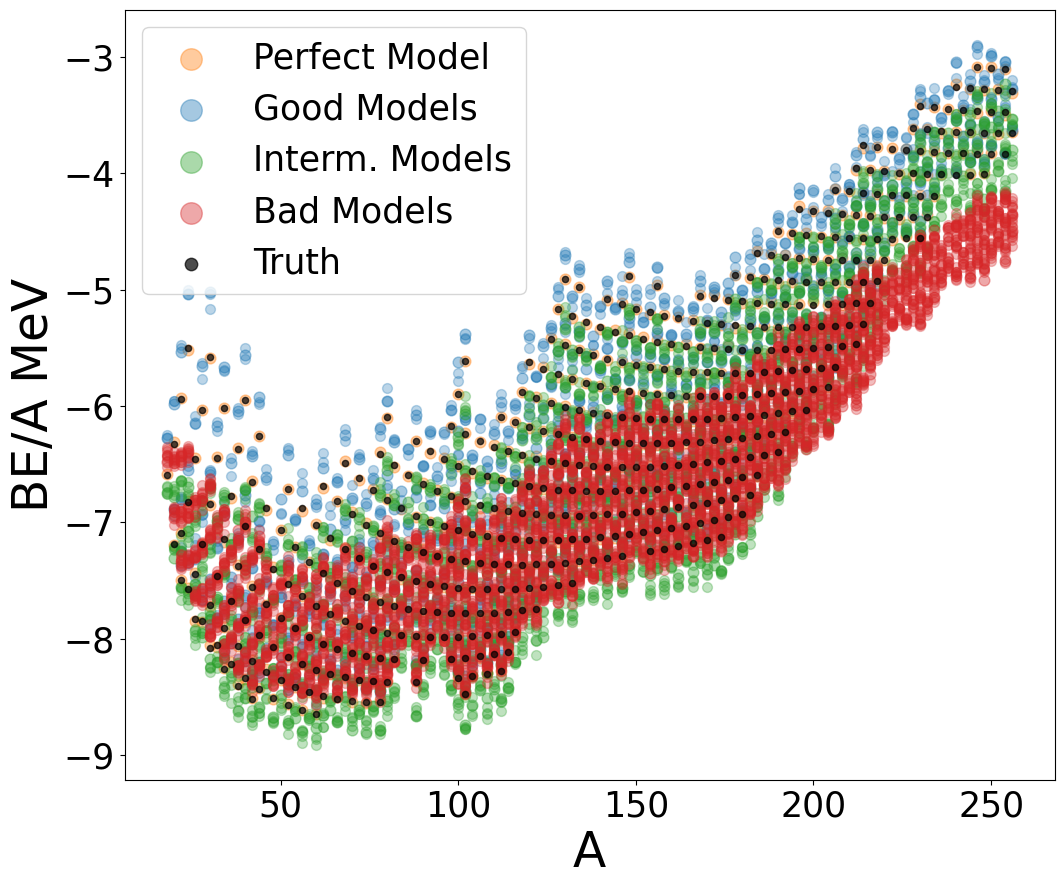

In [260]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.scatter(x = models_output_df["A"], y = models_output_df[key_list[model_index]], label = n_Labels[class_index], alpha = 0.4,color=colors[class_index],marker=markers[0],s=60)
        else:
            ax.scatter(x = models_output_df["A"], y = models_output_df[key_list[model_index]],  alpha = 0.3,color=colors[class_index],marker=markers[0],s=50)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = models_output_df["A"], y = models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=20)


plt.xlabel("A",fontsize=35)
plt.ylabel("BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [287]:
key_list

['PerfectModel_0',
 'GoodModel_0',
 'GoodModel_1',
 'GoodModel_2',
 'IntermediateModel_0',
 'IntermediateModel_1',
 'IntermediateModel_2',
 'IntermediateModel_3',
 'IntermediateModel_4',
 'BadModel_0',
 'BadModel_1',
 'BadModel_2',
 'BadModel_3',
 'BadModel_4',
 'BadModel_5',
 'BadModel_6',
 'BadModel_7',
 'BadModel_8',
 'BadModel_9']

In [261]:
residuals = models_output['truth'].values[:,None] - models_output_df[key_list].values 

residuals_train = models_output_train['truth'].values[:,None] - models_output_train[key_list].values 

residualss_test  = models_output_test['truth'].values[:,None] - models_output_test[key_list].values 



model_predictions=models_output_df[key_list].values
model_predictions_train=models_output_train[key_list].values
model_predictions_test=models_output_test[key_list].values






model_summary = {}
# model_summary["mean"] = models_output_df[models_output.keys()].mean(axis = 0).values
# model_summary["std"] = models_output_df[models_output.keys()].std(axis = 0).values
# model_summary["res_mean"] = residuals.mean(axis = 0)
# model_summary["res_std"] = residuals.std(axis = 0)
model_summary["rmse_all"] = np.sqrt(np.mean(residuals ** 2, axis = 0))
model_summary["rmse_train"] = np.sqrt(np.mean(residuals_train ** 2, axis = 0))
model_summary["rmse_test"] = np.sqrt(np.mean(residualss_test ** 2, axis = 0))


model_summary_df = pd.DataFrame(model_summary, index =key_list)
print(model_summary_df)
print(model_summary_df.style.format(precision = 2).to_latex())
#print(model_summary_df.to_latex(float_format="%.2f"))

                     rmse_all  rmse_train  rmse_test
PerfectModel_0       0.010387    0.010467   0.010201
GoodModel_0          0.147652    0.146615   0.150028
GoodModel_1          0.146309    0.144496   0.150429
GoodModel_2          0.146609    0.145803   0.148459
IntermediateModel_0  0.305119    0.304363   0.306867
IntermediateModel_1  0.302654    0.301759   0.304718
IntermediateModel_2  0.307453    0.306272   0.310176
IntermediateModel_3  0.306691    0.306642   0.306804
IntermediateModel_4  0.306085    0.303493   0.312013
BadModel_0           0.593913    0.579605   0.625828
BadModel_1           0.592238    0.577611   0.624834
BadModel_2           0.593506    0.580189   0.623286
BadModel_3           0.596250    0.580154   0.631993
BadModel_4           0.594728    0.581638   0.624021
BadModel_5           0.592884    0.581370   0.618755
BadModel_6           0.595070    0.583013   0.622126
BadModel_7           0.594446    0.581163   0.624158
BadModel_8           0.589361    0.575450   0.

In [262]:
Z_range=(20,20)
N_range=(0,300)


filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
                     (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

filtered_models_output_test = models_output_test[(models_output_test['Z'] >= Z_range[0]) & (models_output_test['Z'] <= Z_range[1]) & 
                     (models_output_test['N'] >= N_range[0]) & (models_output_test['N'] <= N_range[1])]


filtered_models_output_train = models_output_train[(models_output_train['Z'] >= Z_range[0]) & (models_output_train['Z'] <= Z_range[1]) & 
                     (models_output_train['N'] >= N_range[0]) & (models_output_train['N'] <= N_range[1])]

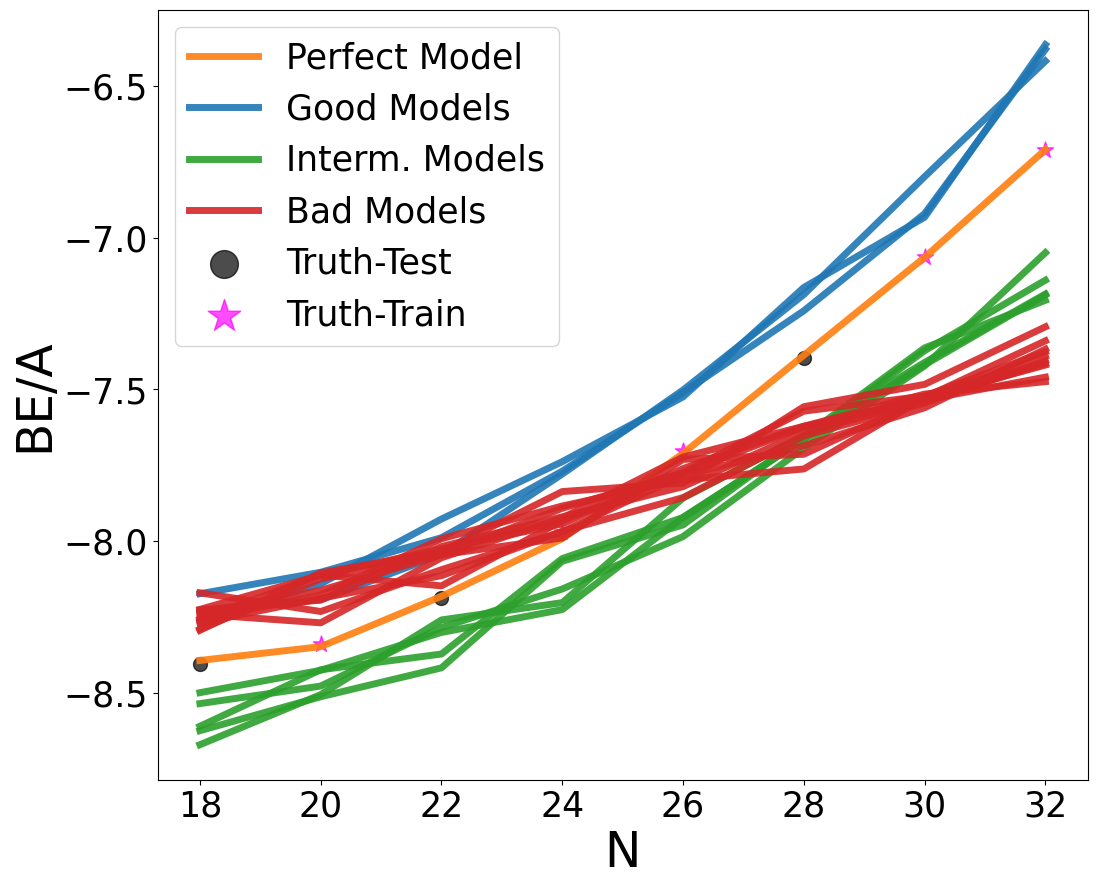

In [263]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth-Test", alpha = 0.7,color='k',s=100)
ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'], label = "Truth-Train", alpha = 0.7,color='magenta',s=150,marker="*")


plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_Calcium_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [289]:
np.shape(model_predictions_train)

(364, 19)

## PCA - Analysis (with centering)

In [264]:
predictions_mean= np.mean(model_predictions, axis=1)
predictions_train_mean= np.mean(model_predictions_train, axis=1)
predictions_test_mean= np.mean(model_predictions_test, axis=1)

In [270]:
model_predictions_train_centered=np.array([model_predictions_train.T[j]-predictions_train_mean for j in range(len(model_predictions_train.T))]).T

In [294]:
model_predictions_train_centered

array([[ 0.40379169,  0.63942631,  0.63381752, ..., -0.25675647,
        -0.28720517, -0.30333915],
       [ 0.25207984,  0.5095933 ,  0.53803732, ..., -0.17920015,
        -0.10284543, -0.02720317],
       [ 0.28360665,  0.45285805,  0.48536425, ..., -0.16863054,
        -0.20985239, -0.16421231],
       ...,
       [ 0.62677889,  0.76042023,  0.70747106, ..., -0.46810295,
        -0.50086012, -0.46674331],
       [ 0.24913384,  0.3459564 ,  0.33637256, ..., -0.11645496,
        -0.00496252, -0.08800146],
       [ 0.26948915,  0.35798588,  0.30707481, ..., -0.07524847,
        -0.11983225, -0.08569556]])

In [290]:
U, S, Vt = np.linalg.svd(model_predictions_train_centered)

In [291]:
S

array([2.16912001e+01, 7.48090920e+00, 1.08585893e+00, 1.04277894e+00,
       1.02351714e+00, 1.00653208e+00, 1.00184345e+00, 9.65756962e-01,
       9.50294685e-01, 9.38113613e-01, 9.24970652e-01, 8.92427069e-01,
       8.82663602e-01, 8.49393243e-01, 8.32503902e-01, 8.22109755e-01,
       7.79976444e-01, 6.73292151e-01, 7.48652893e-14])

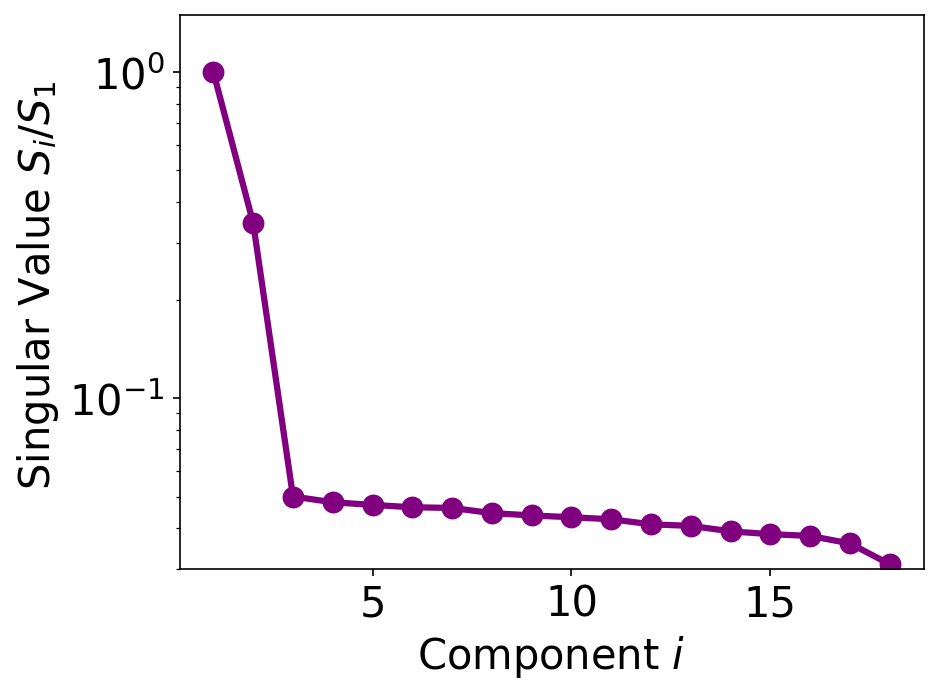

In [273]:
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)


fig, ax = plt.subplots(dpi=150)
fig.patch.set_facecolor('white')

ax.scatter(np.arange(1,S.size), S[0:-1]/S[0],color='purple',s=90)
ax.plot(np.arange(1,S.size), S[0:-1]/S[0],color='purple',linewidth=3)

ax.set_yscale('log')
ax.set_xlabel(r'Component $i$',fontsize=20)
ax.set_ylabel(r' Singular Value $S_i/S_1$',fontsize=20);
plt.ylim(3*10**(-2),1.5)
# plt.title("Singular values decay",fontsize=30)
plt.show()

In [274]:
components_kept=2
S_hat=np.array([S[i] for i in range(components_kept)])

U_hat=np.array([U.T[i]*S_hat[i] for i in range(components_kept)])

Vt_hat=np.array([Vt[i] for i in range(components_kept)])


In [275]:
#Creating principal components that are valid everywhere (testing + training)
models_PC = {}
models_PC[str("PC_0")] = predictions_mean
for i in range(components_kept):
    # models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)*S_hat[i]
    models_PC[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions.T)

models_PC = pd.DataFrame(models_PC)
models_PC["N"] = input_NZ["N"]
models_PC["Z"] = input_NZ["Z"]
models_PC["A"] = models_PC["N"] + models_PC["Z"]

In [276]:
models_PC

PC_0      PC_1      PC_2    N    Z    A
0   -6.489659 -0.010581 -0.665991   10    8   18
1   -6.447424 -0.509408 -0.927614   12    8   20
2   -6.329464 -1.174042 -1.245525   14    8   22
3   -6.225430 -1.777080 -1.810591   16    8   24
4   -7.017391  0.209106 -0.580918   10   10   20
..        ...       ...       ...  ...  ...  ...
516 -4.190589 -1.772211  0.241997  152  100  252
517 -4.037065 -1.856439  0.311984  154  100  254
518 -3.892426 -1.925885  0.415723  156  100  256
519 -4.347021 -1.499511  0.232028  152  102  254
520 -4.164138 -1.628156  0.320425  154  102  256

[521 rows x 6 columns]

In [277]:
S_hat

array([21.69120009,  7.4809092 ])

In [278]:
#Creating principal components that are for testing



models_PC_testing = {}


models_PC_testing[str("PC_0")] = predictions_test_mean
for i in range(components_kept):
    # models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)*S_hat[i]
    models_PC_testing[str("PC_")+str(i+1)] = np.dot(Vt_hat[i],model_predictions_test.T)

models_PC_testing["N"] = models_output_test["N"]
models_PC_testing["Z"] = models_output_test["Z"]
models_PC_testing["A"] = models_PC_testing["N"] + models_PC_testing["Z"]

models_PC_testing = pd.DataFrame(models_PC_testing)






In [279]:
filtered_models_PC = models_PC[(models_PC['Z'] >= Z_range[0]) & (models_PC['Z'] <= Z_range[1]) & 
                     (models_PC['N'] >= N_range[0]) & (models_PC['N'] <= N_range[1])]

In [280]:
key_list_PCs=list(filtered_models_PC.keys())

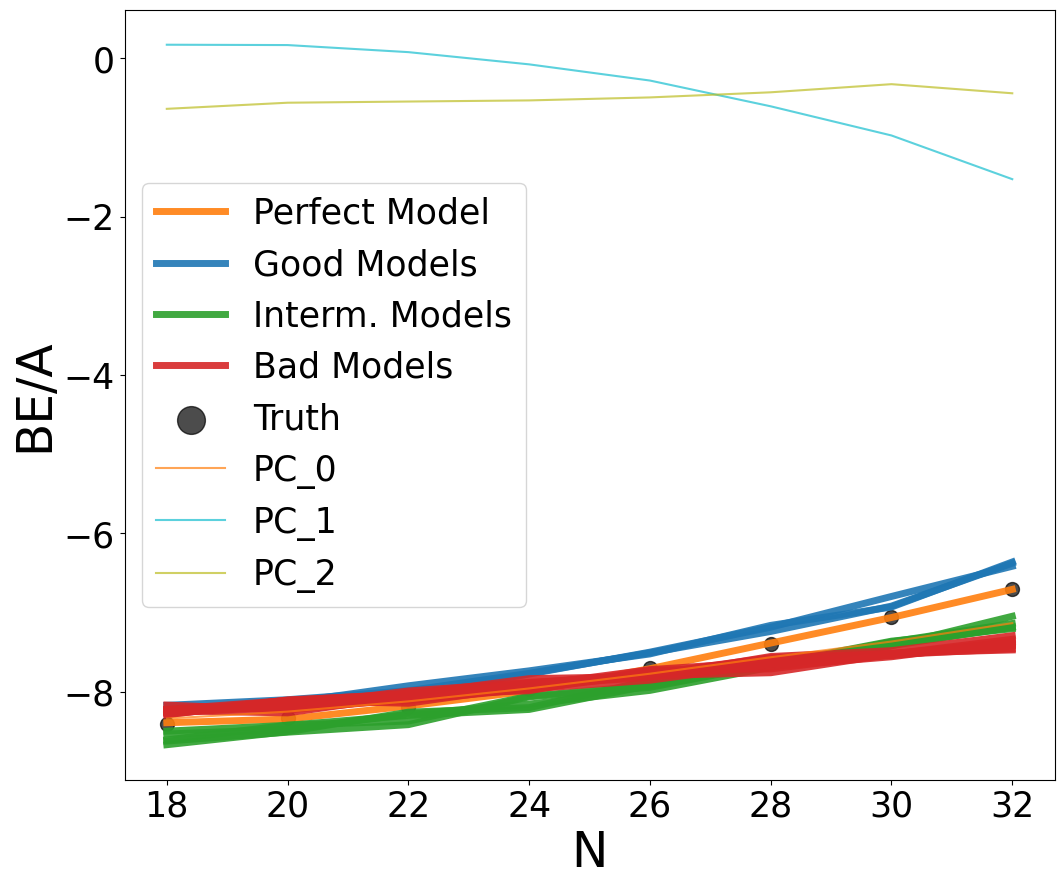

In [281]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)


model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = 0.9,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = 0.9,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0







ax.scatter(x = filtered_models_output["N"], y = filtered_models_output['truth'], label = "Truth", alpha = 0.7,color='k',s=100)

for i in range(components_kept+1):
    ax.plot(filtered_models_PC["N"], filtered_models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])






plt.xlabel("N",fontsize=35)
plt.ylabel("BE/A",fontsize=35)
plt.legend(fontsize=25,markerscale=2 )
plt.savefig("LDM_Data_Calcium_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

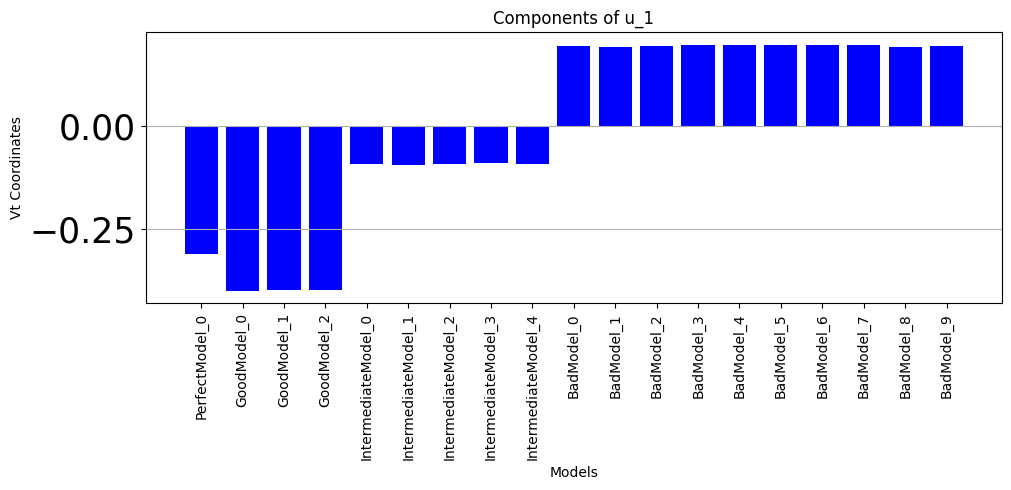

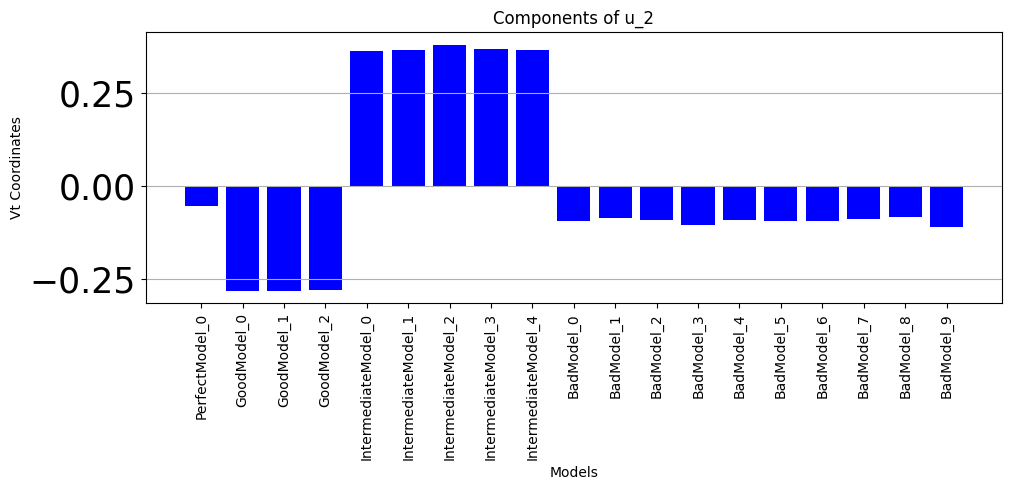

In [282]:


for i in range(len(Vt_hat)):

    plot_bars(Vt_hat[i], key_list, title=f"Components of u_{i+1}", color='blue')

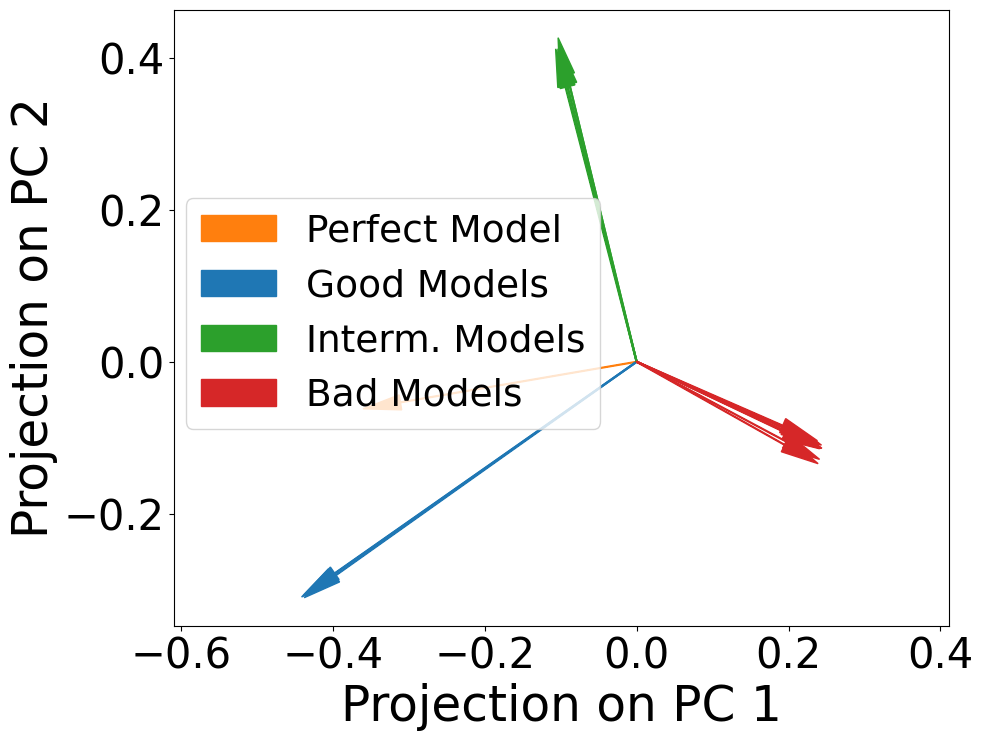

In [283]:

plt.rc("xtick", labelsize=30)
plt.rc("ytick", labelsize=30)

fig, ax = plt.subplots(figsize=(10,8), dpi=100)

model_index=0
class_index=0

visited_model=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1

            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index],label=n_Labels[class_index])
           
        else:
            plt.arrow(0, 0, Vt_hat.T[visited_model][0], Vt_hat.T[visited_model][1], head_width=0.02, head_length=0.05, fc=colors[class_index], ec=colors[class_index])
        model_index=model_index+1
        visited_model=visited_model+1
    class_index=class_index+1
    legend_flag=0


# Determine plot limits based on the maximum absolute values of the vectors
# max_val = max(max(abs(coordinate) for vector in list1 + list2 for coordinate in vector))
# plt.xlim(-max_val-1, max_val+1)
# plt.ylim(-max_val-1, max_val+1)

plt.xlabel('Projection on PC 1',fontsize=35)
plt.ylabel('Projection on PC 2',fontsize=35)

plt.legend(loc=(0.015, 0.32),fontsize=27)

plt.axis('equal')

plt.show()


In [244]:
X=np.copy(U_hat)
y=np.copy(models_output_train["truth"].tolist())-predictions_train_mean

In [246]:
#Making the list of principal components across the entire chart (training+testing)
X_full=[]
for i in range(components_kept+1):
    X_full.append(models_PC[key_list_PCs[i]].tolist())
X_full=np.array(X_full)

In [247]:
#Making the list of principal components across the testing part
X_test=[]
for i in range(components_kept+1):
    X_test.append(models_PC_testing[key_list_PCs[i]].tolist())
X_test=np.array(X_test)

In [248]:
# 1) Find the least square solution for the training part
X_T_X_inv = np.linalg.inv(X.dot(X.T))
beta = X_T_X_inv.dot(X).dot(y)
supermodel=X.T.dot(beta)

#1.5) Construct the super model across the entire range and the test range
beta_full= np.insert(beta, 0, 1)  #Augmenting the beta list to add a "1" at the begining so it can use the PC0 (the mean)
supermodel_full=X_full.T.dot(beta_full)
supermodel_test=X_test.T.dot(beta_full)


# 2) Construct the covariance matrix
residuals = y - supermodel
sigma_squared = np.sum(residuals**2) / len(residuals) 
cov_matrix = sigma_squared * X_T_X_inv

# 3) Make a corner plot
samples = np.random.multivariate_normal(beta, cov_matrix, size=500000)


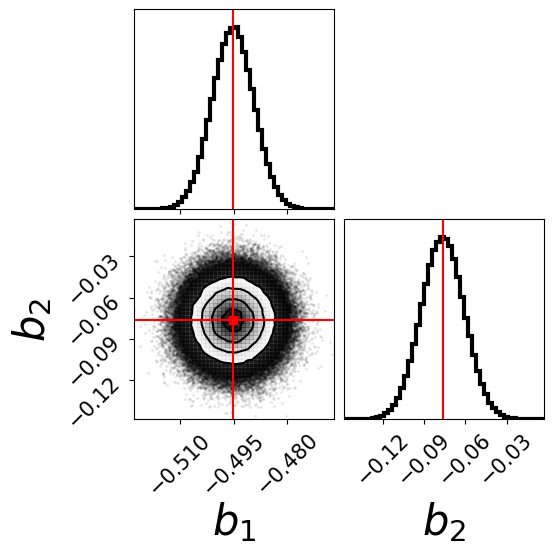

In [249]:
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)

figure = corner.corner(samples,bins=50, dpi=300, hist_kwargs={"linewidth": 3},
                       labels=[f'$b_{i}$' for i in range(1, len(beta) + 1)], truths=beta,truth_color="r",
                       label_kwargs={"fontsize": 30},labelpad=0.1)


plt.show()

In [23]:
# # 4) Make a corner plot in the space of the original models
# samples_original_space = np.array([np.dot(betaval,Vt_hat)  for  betaval in samples])


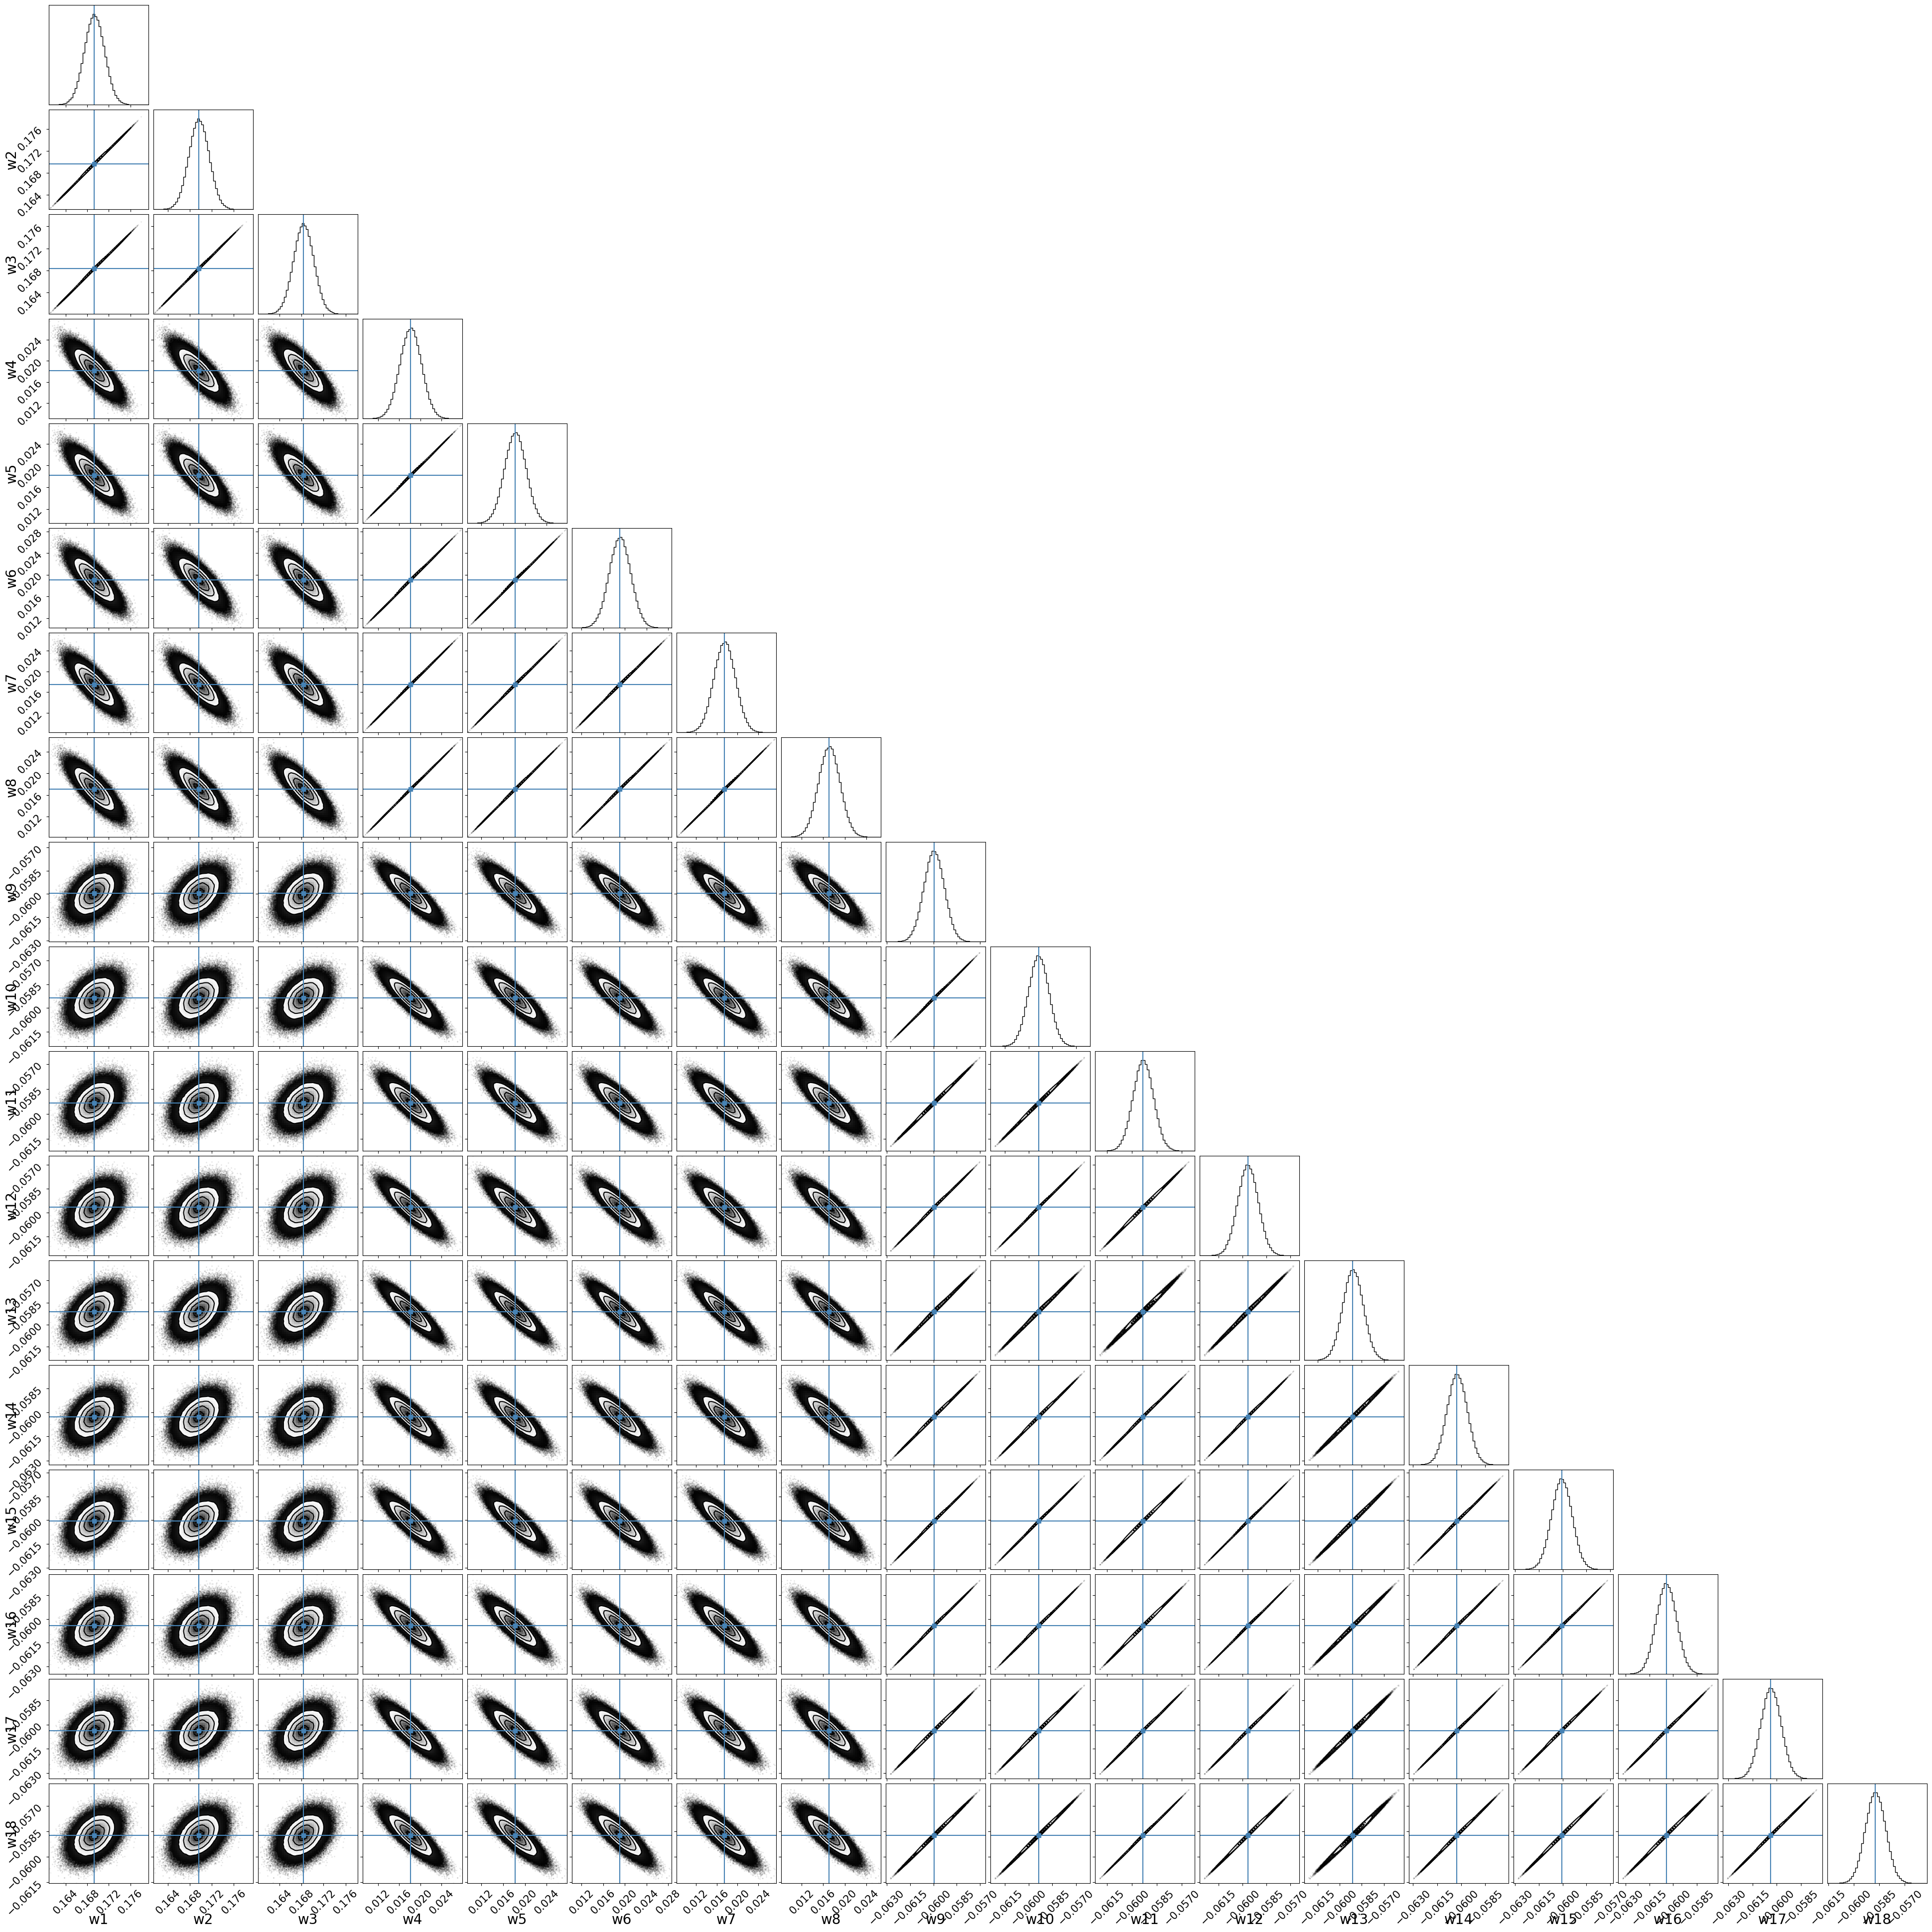

In [24]:


# figure = corner.corner(samples_original_space, bins=50, labels=[f'w{i}' for i in range(1, len(Vt_hat.T) + 1)], truths=np.dot(beta,Vt_hat),label_kwargs={"fontsize": 20})
# # figure = corner.corner(samples_original_space)

# plt.show()

In [250]:
beta

array([-0.4952689, -0.0765431])

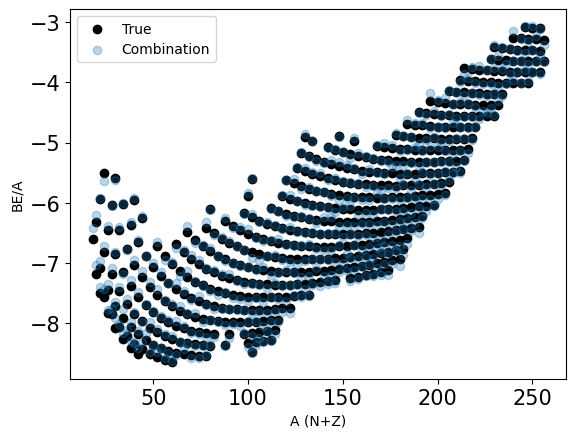

In [251]:
# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = models_output['truth'], label = str("True"), color='k')



# for key in models_output.keys():
#     plt.scatter(x = models_output_df["A"], y = models_output_df[key], label = key, alpha = 0.5)
# # 


# # for i in range(components_kept):
# plt.scatter(x = models_output_df["A"], y =U_hat.T[0], label = str("PC_") + str(0), alpha = 0.3)
# plt.scatter(x = models_output_df["A"], y = U_hat.T[1], label = str("PC_") + str(1), alpha = 0.3)
# for i in range(components_kept+1):
#     ax.plot(models_PC["A"], models_PC[key_list_PCs[i]], label =key_list_PCs[i], alpha = 0.7,color=colors[-i])


# plt.scatter(x = models_output_df["A"], y = np.array([sum(beta_val * UList for beta_val, UList in zip(beta, U_hat.T))]), label = str("Combination"), alpha = 0.3)


plt.scatter(x = models_output_df["A"], y = supermodel_full, label = str("Combination"), alpha = 0.3)


plt.legend()

plt.xlabel('A (N+Z)')

plt.ylabel('BE/A')

plt.show()

In [17]:
# Z_range=(20,20)
# N_range=(0,300)


# filtered_models_output = models_output_df[(models_output_df['Z'] >= Z_range[0]) & (models_output_df['Z'] <= Z_range[1]) & 
#                      (models_output_df['N'] >= N_range[0]) & (models_output_df['N'] <= N_range[1])]

In [18]:
# Predictions_supermodel=supermodel[filtered_models_output.index]
# masses_truth_filtered= np.array(masses_truth.tolist())[filtered_models_output.index]

In [252]:
#Restricting the super model to plot on the selected isotope (Calcium)
X_full_filtered=[]

for i in range(len(X_full)):
    X_full_filtered.append(X_full[i][filtered_models_output.index])
X_full_filtered=np.array(X_full_filtered)

In [253]:
rng = np.random.default_rng()
theta_rand = rng.choice(samples, (50000), replace=False)
rndm_m = []

for i in range(len(theta_rand)):
    yvals_rand= X_full_filtered.T.dot(np.insert(theta_rand[i], 0, 1))
    rndm_m.append(yvals_rand +
                   np.random.multivariate_normal(np.full(
                       len(yvals_rand)
                       ,0), np.diag(1.0 * np.full(len(yvals_rand),1.0 * sigma_squared ) )))   

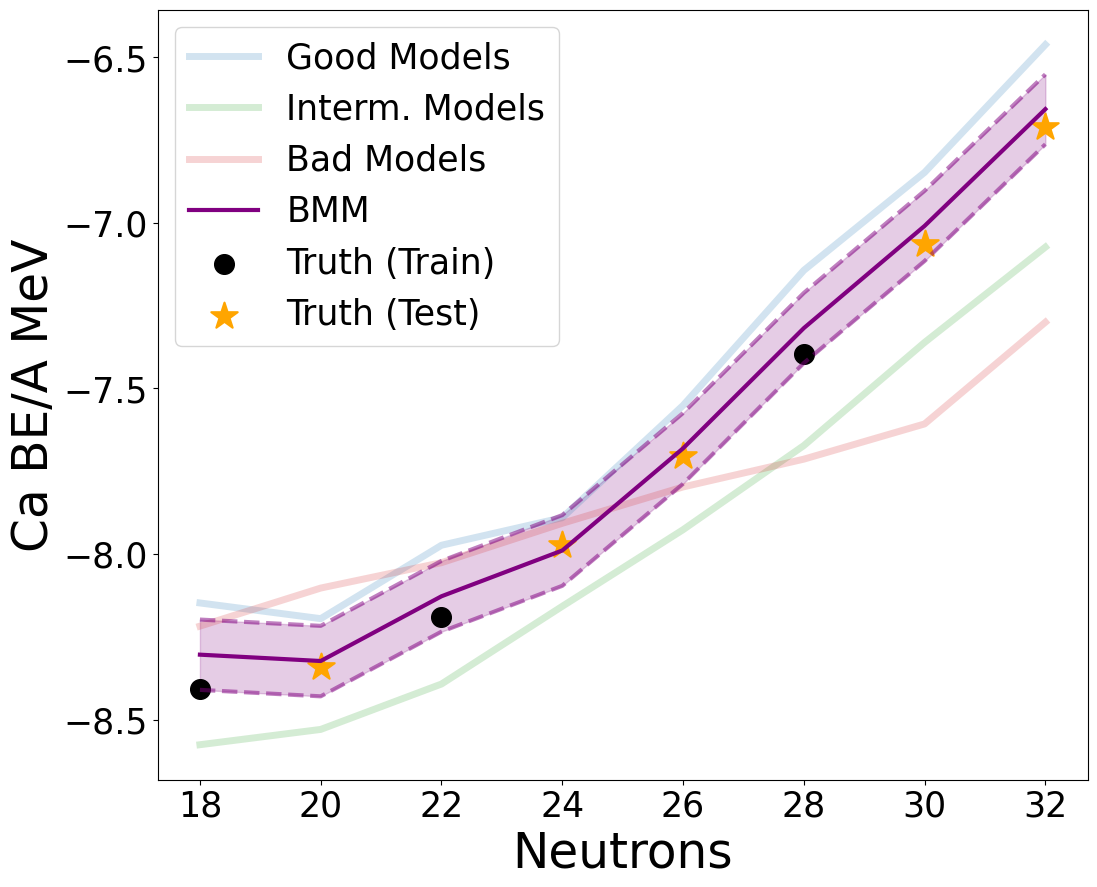

In [254]:
plt.rc("xtick", labelsize=25)
plt.rc("ytick", labelsize=25)

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

alpha_models=0.2

model_index=0
class_index=0
for n_vals in n_classes:
    legend_flag=0
    for i in range(n_vals):
        if legend_flag==0:
            legend_flag=1
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
           
        else:
            ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], color=colors[class_index],alpha = alpha_models,linewidth=5)
        model_index=model_index+1
    class_index=class_index+1
    legend_flag=0







mean = np.mean(rndm_m,axis=0)
upper = (np.percentile(rndm_m, 97.5, axis=0))



lower = (np.percentile(rndm_m, 2.5, axis=0))

plt.plot(filtered_models_output["N"], mean, color="purple", label='BMM',linewidth=3)

plt.plot(filtered_models_output["N"], lower, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)
plt.plot(filtered_models_output["N"], upper, color="purple",linestyle="dashed",linewidth=3,alpha=0.5)

plt.fill_between(filtered_models_output["N"], lower, upper, color="purple",alpha=0.2)





ax.scatter(x = filtered_models_output_train["N"], y = filtered_models_output_train['truth'], label = "Truth (Train)",color='k',s=200)
ax.scatter(x = filtered_models_output_test["N"], y = filtered_models_output_test['truth'],
            label = "Truth (Test)",color='orange',s=400,marker="*",edgecolor='face', linewidth=1.5,alpha=1)








plt.xlabel("Neutrons",fontsize=35)
plt.ylabel("Ca BE/A MeV",fontsize=35)
plt.legend(fontsize=25,markerscale=1 )
plt.savefig("LDM_Data_Calcium_"+scenario+".pdf", format="pdf", bbox_inches="tight")
plt.show()

In [255]:
super_model_residuals_test = supermodel_test-models_output_test['truth'].tolist()

In [256]:
sigma_test=np.sqrt(np.sum(super_model_residuals_test**2) / len(super_model_residuals_test) )

In [257]:
sigma_test

0.04946144100762363

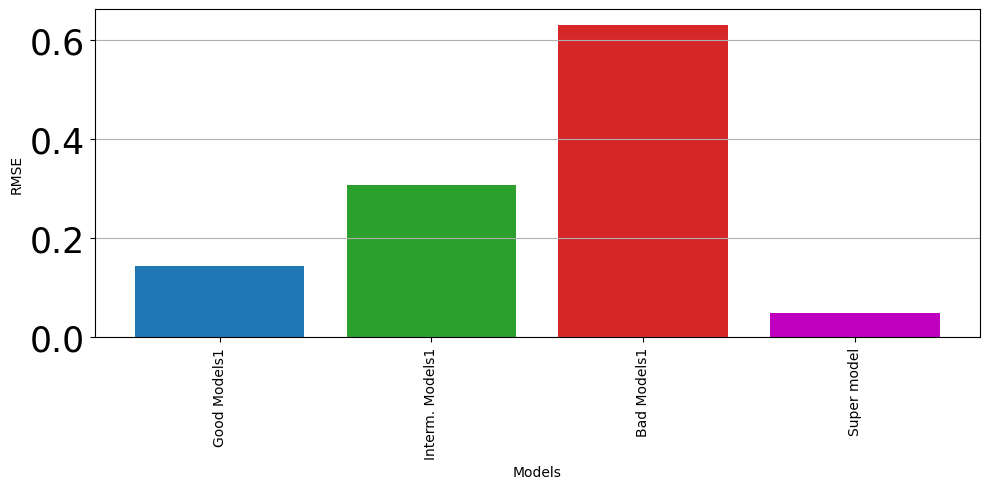

In [258]:
labels=list(models_output.keys())
plt.figure(figsize=(10, 5))

rmse=[]

model_index=0
class_index=0
for n_vals in n_classes:
    rmse_av=0
    for i in range(n_vals):
        
        # ax.plot(filtered_models_output["N"], filtered_models_output[key_list[model_index]], 
        #         label = n_Labels[class_index], color=colors[class_index],alpha = alpha_models,linewidth=5)
        plt.bar(n_Labels[class_index] + str(i+1) , model_summary["rmse_test"][model_index], color=colors[class_index])
        rmse_av=rmse_av+model_summary["rmse_test"][model_index]
        model_index=model_index+1
    if n_vals!=0:
        rmse.append(rmse_av/n_vals)
    class_index=class_index+1




# plt.bar(labels[0:1] , model_summary["rmse_test"][0:1], color='b')

# plt.bar(labels[1:] , model_summary["rmse_test"][1:], color='r')

plt.bar('Super model' , sigma_test, color='m')

plt.xlabel('Models')
plt.ylabel('RMSE')
plt.xticks(fontsize=10,rotation='vertical')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [151]:
rmse

[0.14828814184725733, 0.3072399197076589, 0.623736691561068]